# EDA for UCI thyroid dataset

## Basic inspection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
input_path = '../../input/uci_thyroid'
col_names = [
    'age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
    'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
    'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
    'psych', 'TSH', 'T3', 'TT4', 'T4U', 
    'FTI', 'class'
]
df = [
    pd.read_csv(
        f'{input_path}/ann-{tag}.data', header=None, names=col_names,
        delim_whitespace=True
    )
    for tag in ['train', 'test']
]
df = pd.concat([
    pd.concat(df, axis=0, ignore_index=True), 
    pd.Series([0]*len(df[0]) + [1]*len(df[1]), name='test')
], axis=1)

In [2]:
print('duplication test')
print(df.duplicated().value_counts() )
df = df.drop_duplicates()
df.shape
df_train, df_test = df[df['test'] == 0], df[df['test'] == 1]

print()
print(f'number of train samples : {df_train.shape[0]}')
print(f'number of  test samples : { df_test.shape[0]}')

duplication test
False    7129
True       71
dtype: int64

number of train samples : 3709
number of  test samples : 3420


In [3]:
df.dtypes
# By default, pandas keeps numeric values as 64-bit dtypes. 
# When dataset is huge, reducing into 32-bit dtypes makes works faster.
# For current datset, such reduction seems unnecessary.

age                          float64
sex                            int64
on thyroxine                   int64
query on thyroxine             int64
on antithyroid medication      int64
sick                           int64
pregnant                       int64
thyroid surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
class                          int64
test                           int64
dtype: object

In [4]:
df.isna().sum().sum()

0

**Observation**
- small amount of duplications

- some continuous, some boolean

- no NaN inside the dataset

In [5]:
conti_names = [
    'age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'
]
bool_names = [
    'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
    'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
    'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
    'psych', 
]

This dataset lacks detailed description. Therefore it was difficult to understand the meaning of each feature. 

Anyway, it was possible to find out the following:

- *TSH*, *T3*, *TT4*, *T4U*, *FTI* are values related to hormones.

- I131 = iodine-131, isotope of iodine

- *goitre* = swollen throat due to thyroid anomaly

- *hypopituitary* = hypo + pituitary, i.e. pituitary(뇌하수체) being weak

## Histograms: distributions of individual variables

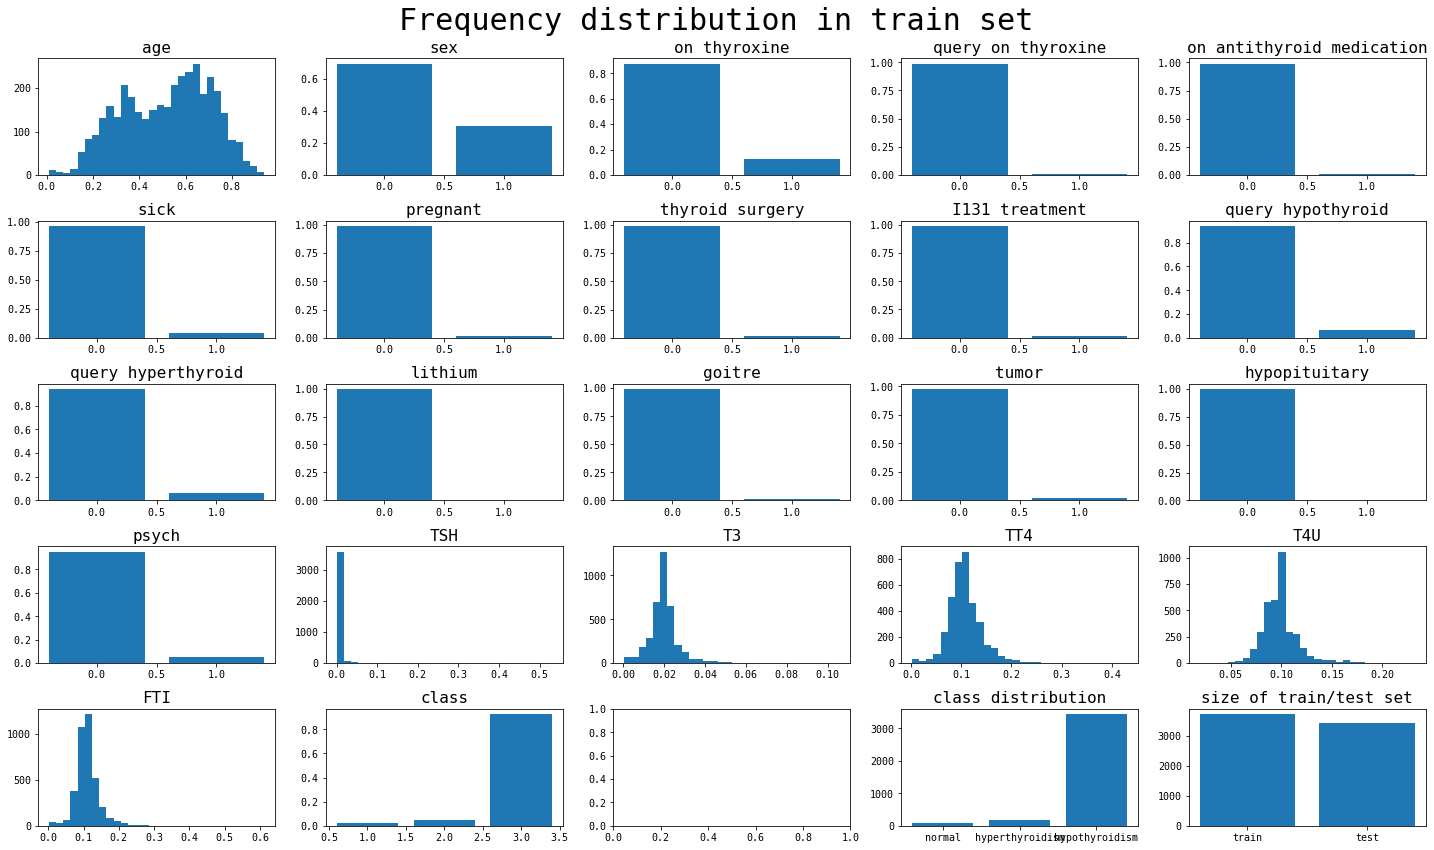

In [6]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 12))
axs = axs.ravel()
for num, name in enumerate(col_names):
    ax = axs[num]
    title = name
    ser = df_train[name]
    # if name in ['TSH']:
    #     ser = np.log(1e-5+ser)
    #     title = f'{name} (log scale)'
    _, bins = np.histogram(ser, bins=30)
    if name in ['TSH', 'age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
        ax.hist(ser, bins=bins, color='C0')
    else:
        ax.bar(np.sort(ser.unique()), ser.value_counts(normalize=True).sort_index(), color='C0')
    ax.set_title(title, fontsize=16)

ax = axs[-2]
for j in range(1, 1+3):
    ax.bar([j], [(df_train['class'] == j).sum()], color='C0')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['normal', 'hyperthyroidism', 'hypothyroidism'])
ax.set_title('class distribution', fontsize=16)

ax = axs[-1]
ax.bar(['train', 'test'], [(df['test'] == 0).sum(), (df['test'] == 1).sum()], color='C0')
ax.set_title('size of train/test set', fontsize=16)

fig.suptitle('Frequency distribution in train set', fontsize=30)
plt.tight_layout()
plt.show(); plt.close()

In [7]:
df['hypopituitary'].value_counts()

0    7128
1       1
Name: hypopituitary, dtype: int64

In [8]:
df[['sex', 'pregnant']].drop_duplicates()

,sex,pregnant
0,0,0
3,1,0
52,0,1


**observations**
- boolean variables and class are largely skewed

- only one positive sample for *hypopituitary* (therefore we should throw it away)

- *sex* 0 = female, 1 = male

- *TSH* is concentrated near zero (log transform needed)

- other continuous variables are approximately normally distributed

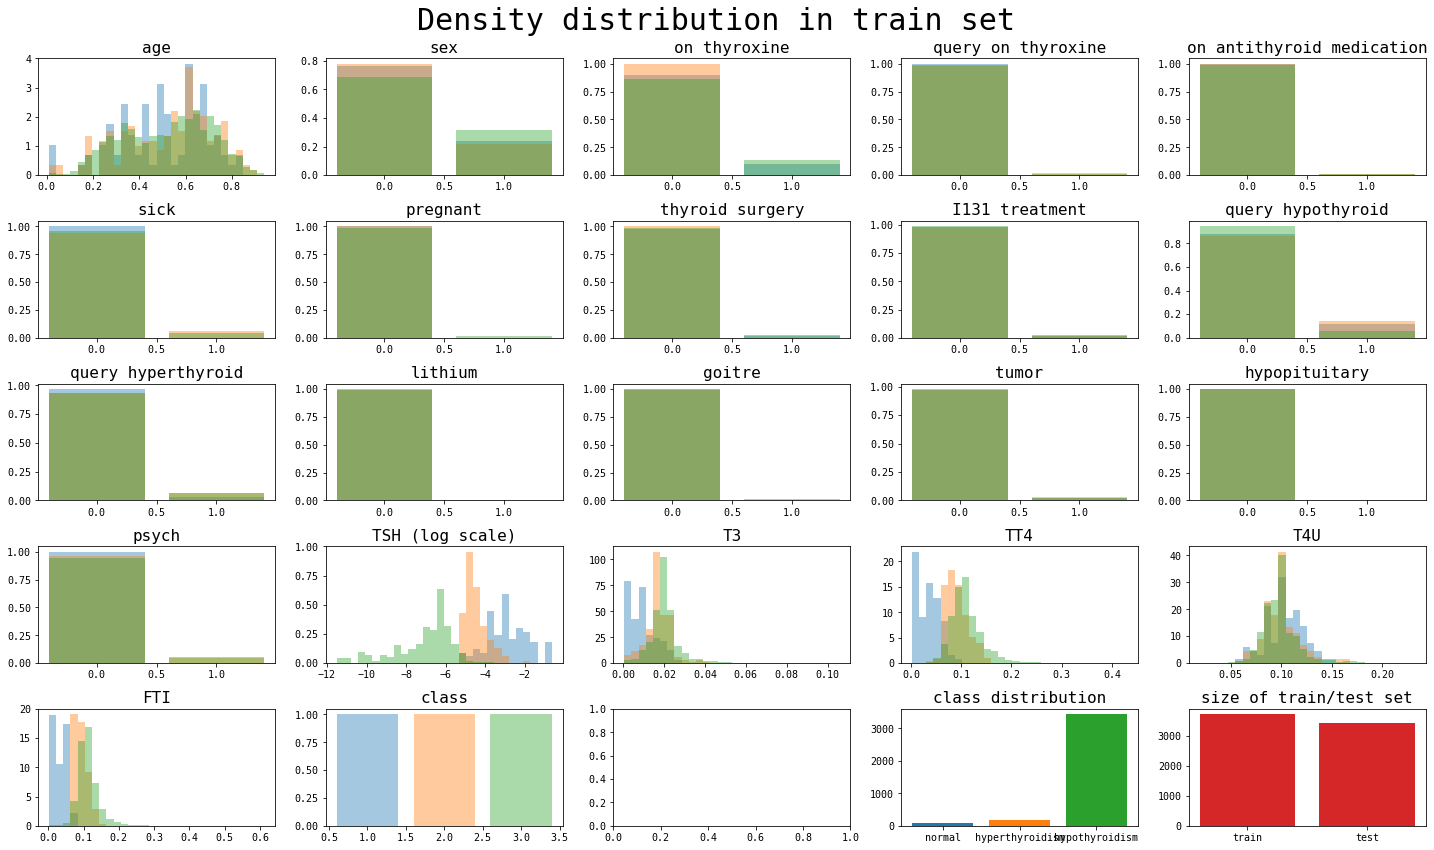

In [9]:
tsh_transform = lambda x: np.log(1e-5 + x)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 12))
axs = axs.ravel()
for num, name in enumerate(col_names):
    ax = axs[num]
    title = name
    ser_all = df_train[name]
    if name in ['TSH']:
        ser_all = tsh_transform(ser_all)
        title = f'{name} (log scale)'
    _, bins = np.histogram(ser_all, bins=30)
    alpha = 0.4
    for j in range(1, 1+3):
        ser = ser_all[df_train['class'] == j]
        if name in ['TSH', 'age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
            ax.hist(ser, bins=bins, density=True, color=f'C{j-1}', alpha=alpha)
        else:
            ax.bar(np.sort(ser.unique()), ser.value_counts(normalize=True).sort_index(), color=f'C{j-1}', alpha=alpha)
    ax.set_title(title, fontsize=16)

ax = axs[-2]
for j in range(1, 1+3):
    ax.bar([j], [(df_train['class'] == j).sum()], color=f'C{j-1}')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['normal', 'hyperthyroidism', 'hypothyroidism'])
ax.set_title('class distribution', fontsize=16)

ax = axs[-1]
ax.bar(['train', 'test'], [(df['test'] == 0).sum(), (df['test'] == 1).sum()], color='C3')
ax.set_title('size of train/test set', fontsize=16)

fig.suptitle('Density distribution in train set', fontsize=30)
plt.tight_layout()
plt.show(); plt.close()

In [10]:
print(df_train['class'].value_counts(normalize=True).sort_index())
print(df_test['class'].value_counts(normalize=True).sort_index())

1    0.025074
2    0.051496
3    0.923429
Name: class, dtype: float64
1    0.021345
2    0.051754
3    0.926901
Name: class, dtype: float64


**observations**
- the following variables seems closely related : *sex*, *on thyroxine*, *query hyperthyroid*, *TSH*, *T3*, *TT4*, *FTI*

- model with accuracy < 93% is worse than doing nothing

## Scatterplot and PCA: relation between variables

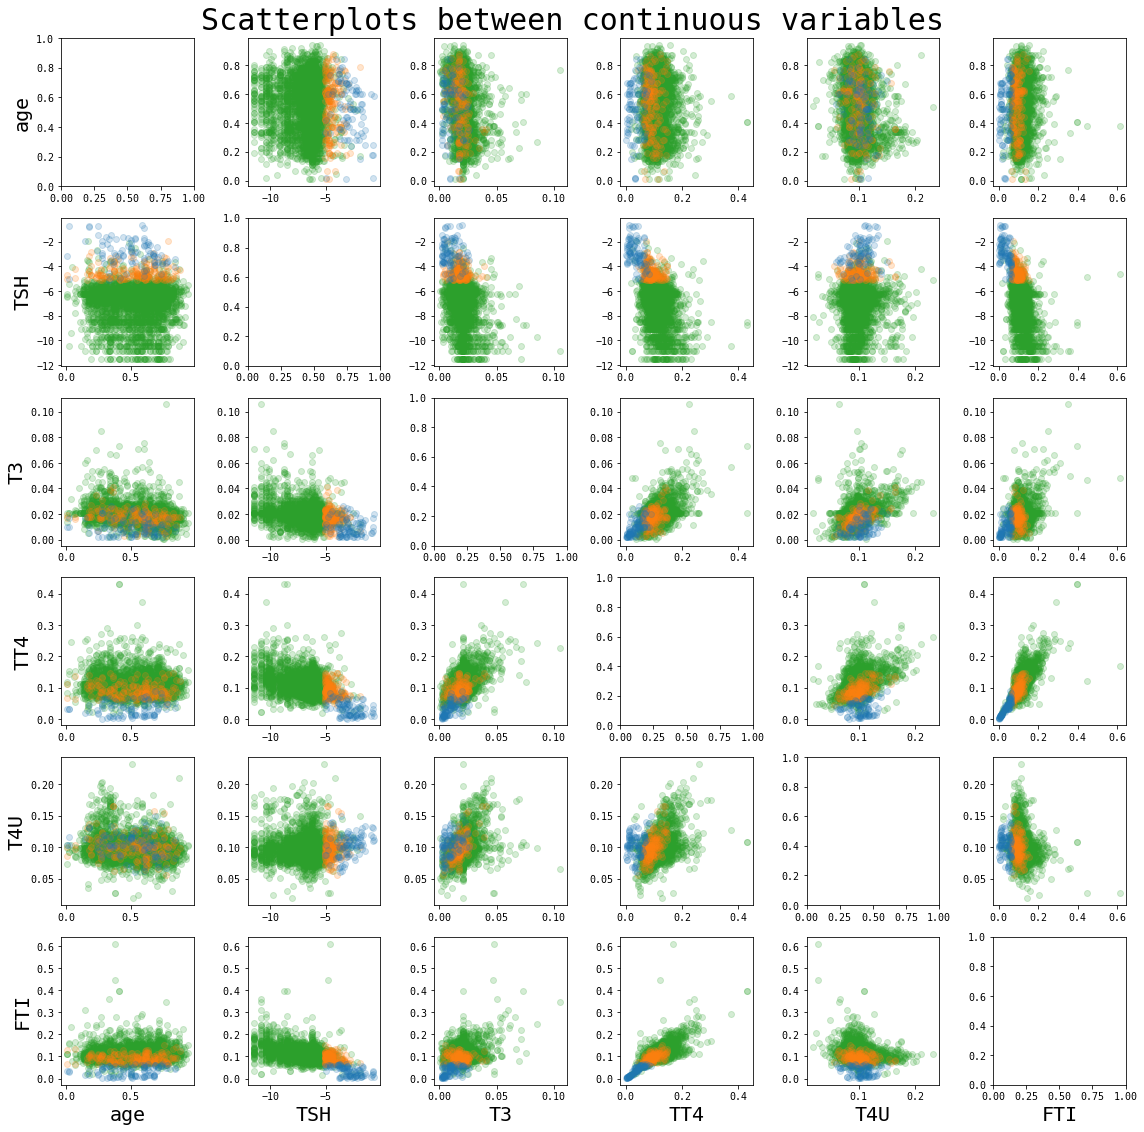

In [11]:
import itertools

vecs = [df_train[name] for name in conti_names]
vecs[1] = tsh_transform(vecs[1])

fig, axs = plt.subplots(nrows=len(vecs), ncols=len(vecs), figsize=(16, 16))
for i, j, k in itertools.product(range(len(vecs)), range(len(vecs)), range(3, 0, -1)):
    ax = axs[j, i]
    mask = df_train['class'] == k
    i == j or ax.scatter(vecs[i][mask], vecs[j][mask], color=f'C{k-1}', alpha=0.2)
    if j+1 == len(conti_names):
        ax.set_xlabel(conti_names[i], fontsize=20)
    if i == 0:
        ax.set_ylabel(conti_names[j], fontsize=20)

fig.suptitle('Scatterplots between continuous variables', fontsize=30)

plt.tight_layout()
plt.show(); plt.close()

In [12]:
from sklearn.decomposition import PCA

conti_vars = np.stack(vecs, axis=1)
conti_vars /= np.std(conti_vars, axis=0)

pca = PCA().fit(conti_vars)
pca.explained_variance_ratio_

array([0.41559128, 0.24390336, 0.14796756, 0.10461608, 0.08238409,
       0.00553762])

**Observation**
- some correlation between continuous variables

- more than 99% of variance explained by linear hyperplane (after standardization)

## More on visualization

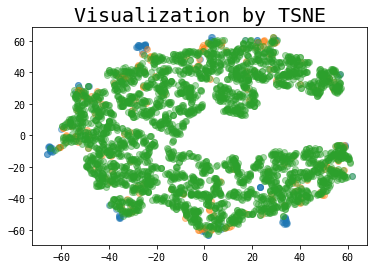

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
reduced_tsne = tsne.fit_transform(df_train[conti_names])
for j in range(1, 1+3):
    plt.scatter(*reduced_tsne[df_train['class'] == j].T, color=f'C{j-1}', alpha=0.4)
plt.title('Visualization by TSNE', fontsize=20)
plt.show(); plt.close()

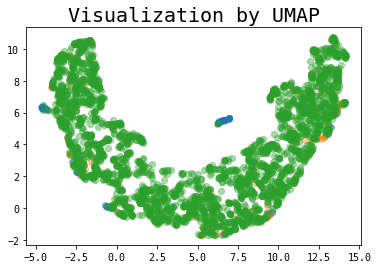

In [14]:
from umap import UMAP

reducer = UMAP(random_state=42)
reduced = reducer.fit_transform(df_train[conti_names])
for j in range(1, 1+3):
    plt.scatter(*reduced[df_train['class'] == j].T, color=f'C{j-1}', alpha=0.4)
plt.title('Visualization by UMAP', fontsize=20)
plt.show(); plt.close()